# survey

> This module handles observation targets, survey duration, and other similar functionality. Currently only for MW surveys.

In [ ]:
#| default_exp survey

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from LensCalcPy.pbh import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
from LensCalcPy.parameters import *
import astropy.coordinates as coord
from astropy import units
import matplotlib.pyplot as plt

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
class Survey:
    """
    A class to represent a survey.
    """

    def __init__(self, 
                 l:float, # Galactic longitude in degrees
                 b: float, # Galactic latitude in degrees
                 source_dist:float, # Distance to observation source in kpc
                 obs_time: float, # Observation time in hours
                 survey_area: float, # Survey area in deg^2
                 n_sources: int, # Number of sources observed in survey
                 n_pbh: int = int(1e2), # Number of PBHs detected
                 n_ffp: int = int(1e4), # Number of FFPs detected
                 ):
     
        self.l = l 
        self.b = b 
        self.source_dist = source_dist 
        self.earth_dist = 8.5 
        self.obs_time = obs_time 
        self.survey_area = survey_area
        self.pbh = None # PBH population
        self.ffp = None # FFP population
        self.n_pbh = n_pbh # Number of PBHs detected
        self.n_ffp = n_ffp # Number of FFPs detected
        self.n_sources = n_sources # Number of sources observed in the Milky Way

    def __str__(self) -> str:
        return f"Survey(l={self.l}, b={self.b}, source_dist={self.source_dist}, obs_time={self.obs_time}, survey_area={self.survey_area})"
    __repr__ = __str__
    
    
    def add_pbh(self, 
                m_pbh: float = 1, # mass of each PBH in solar masses
                f_dm: float = 1, # fraction of DM in PBHs
                ):
        """adds a PBH population to the survey"""
        self.pbh = Pbh(m_pbh, f_dm)
        return
    
    def add_ffp(self,
                mlow: float, # lower mass bound of FFPs in solar masses
                alpha: float, # power law index of FFP mass function
                ):
        """adds a FFP population to the survey"""
        self.ffp = Ffp(mlow, alpha)
    
    def num_pbh(self) -> float:

        """returns the number of PBHs in the line of sight"""

        if self.pbh is None:
            raise ValueError("PBH population not defined")
        
         # Obtain survey area, center latitude, and center longitude
        b_radian = b * np.pi / 180  # rad
        l_radian = l * np.pi / 180  # rad

        # Calculate the field of view for the current field
        field_of_view_radius = (self.survey_area / np.pi) ** (1 / 2)

        # Generate an array of heliocentric radii
        # (Just used to numerically integrate the line-of-sight density)
        n_lin = 100000
        r_h_linspace = np.linspace(0, r_max, num=n_lin)

        # Represent the line-of-sight line as galactic coordinates
        galactic_lin = coord.Galactic(
            l=l_radian * units.rad,
            b=b_radian * units.rad,
            distance=r_h_linspace * units.kpc,
        )

        # Transform the line-of-sight into to galactocentric coordinates
        # (Outputs l, b, and distance [units: deg, deg, kpc])
        galacto_lin = galactic_lin.transform_to(
            coord.Galactocentric(representation_type="spherical")
        )

        # Determine dark matter density at all galactocentric radii along the line-of-sight
        rho_lin = density_mw(galacto_lin.spherical.distance.value)

        # Estimate the total mass within the line-of-sight cylinder [units: M_sun kpc**-2]
        # Total mass = projected line-of-sight density x projected line-of-sight area
        rho_marg_r = np.trapz(rho_lin, dx=(r_max) / n_lin) 
        
        # Determine line-of-sight cylinder radius, assuming small angle approximation [units: kpc]
        r_proj_los_cyl = field_of_view_radius * np.pi / 180 * (r_max)
        # Get projected area of the LOS cylinder [units: kpc**2]
        area_proj_los_cyl = np.pi * r_proj_los_cyl**2
        # Get the total mass within the line-of-sight cylinder
        mass_los_cyl = rho_marg_r * area_proj_los_cyl
        # Get the total number of black holes to randomly draw
        n_pbh = int(np.round(self.pbh.f_dm * mass_los_cyl / self.pbh.m_pbh))
        return n_pbh

    def get_lens_masses(self) -> np.ndarray:
        """returns an array of lens masses"""
        if self.pbh is None:
            raise ValueError("PBH population not defined")
        if self.ffp is None:
            raise ValueError("FFP population not defined")
        print(len(self.ffp.sample_masses), self.n_pbh)
        return np.concatenate((np.ones(self.n_pbh) * self.pbh.m_pbh, self.ffp.sample_masses))
    
    def get_crossing_times_rates_pbh(self,
                                    t_es: np.ndarray,
                                    finite: bool = False,
                                    ) -> np.ndarray:
        if self.pbh is None:
            raise ValueError("PBH population not defined")
        
        return self.pbh.compute_differential_rates(t_es, finite=finite)
    
    def get_crossing_time_rates(self,
                                t_es: np.ndarray,
                                ) -> np.ndarray:
        """returns an array of crossing times"""
        if self.pbh is None:
            raise ValueError("PBH population not defined")
        if self.ffp is None:
            raise ValueError("FFP population not defined")
        
        rates_pbh = np.array([self.pbh.differential_rate(t) for t in t_es])
        rates_ffp = np.array([self.ffp.differential_rate(t) for t in t_es])
    
        #return separately for testing
        return rates_pbh, rates_ffp
    
    
    def get_events_observed(self,
                            t_es: np.ndarray,
                            ) -> np.ndarray:

        
        rates_pbh, rates_ffp = self.get_crossing_time_rates(t_es)
        
        num_pbh_obs = rates_pbh * self.n_sources * self.obs_time 
        num_ffp_obs = rates_ffp * self.n_sources * self.obs_time
        
        return num_pbh_obs, num_ffp_obs
    
    def get_num_events(self,
                       t_es: np.ndarray,
                       ) -> np.ndarray:
       
        num_pbh_obs, num_ffp_obs = self.get_events_observed(t_es)
        
        num_pbh = t_es * num_pbh_obs
        num_ffp = t_es * num_ffp_obs
        
        return np.around(num_pbh), np.around(num_ffp)

In [ ]:
m_pbh = 1e-3
f_dm = 1
mlow = 1e-5
alpha = 2

s = Survey(l, b, ds, obsTime, survey_area, n_sources=n_sources)
s.add_pbh(m_pbh, f_dm)
s.add_ffp(mlow, alpha)

In [ ]:
t_es = np.logspace(-1, 3, 10)
pbh_rates, ffp_rates = s.get_crossing_time_rates(t_es)

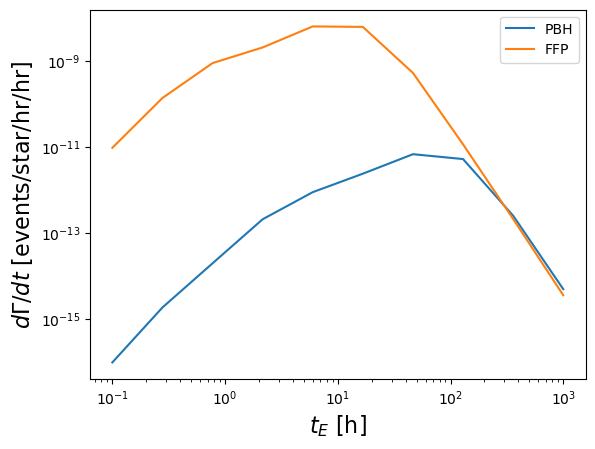

In [ ]:
plt.loglog(t_es, pbh_rates, label="PBH")
plt.loglog(t_es, ffp_rates, label="FFP")

plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)

plt.legend()
plt.show()

In [ ]:
n_pbh_rate, n_ffp_rate = s.get_events_observed(t_es)

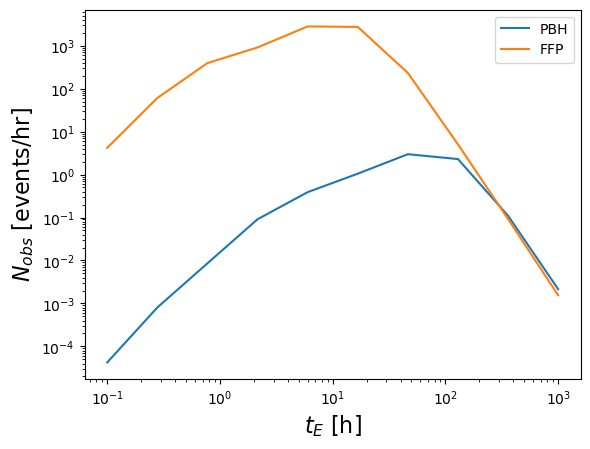

In [ ]:
plt.loglog(t_es, n_pbh_rate, label="PBH")
plt.loglog(t_es, n_ffp_rate, label="FFP")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$N_{obs}$ [events/hr]", fontsize=16)
plt.legend()
plt.show()

In [ ]:
num_pbh, num_ffp = s.get_num_events(t_es)

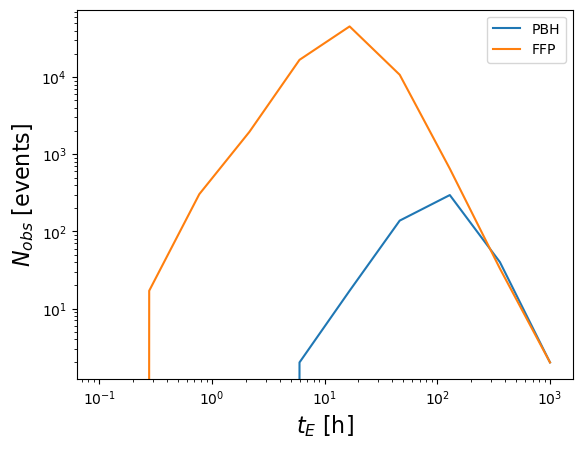

In [ ]:
plt.plot(t_es, num_pbh, label="PBH")
plt.plot(t_es, num_ffp, label="FFP")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$N_{obs}$ [events]", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.show()

In [ ]:
bin_centers = np.sqrt(t_es[1:] * t_es[:-1])
num_pbh_center = (num_pbh[1:] + num_pbh[:-1]) / 2
num_ffp_center = (num_ffp[1:] + num_ffp[:-1]) / 2

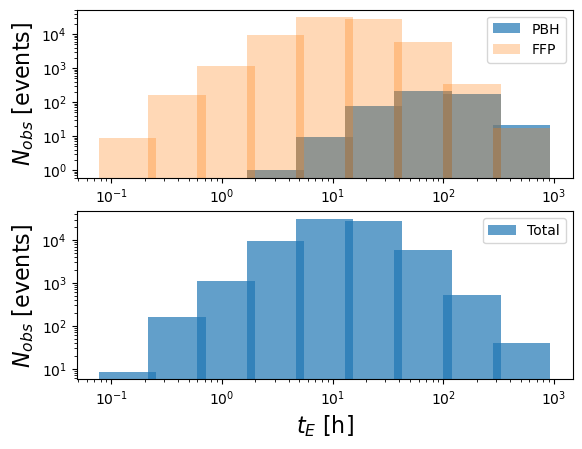

In [ ]:
plt.subplot(211)

plt.bar(bin_centers, num_pbh_center, label="PBH", width = np.diff(t_es), alpha = 0.7)
plt.bar(bin_centers, num_ffp_center, label="FFP", width = np.diff(t_es), alpha = 0.3)
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$N_{obs}$ [events]", fontsize=16)

plt.legend()

plt.subplot(212)
plt.bar(bin_centers, num_pbh_center + num_ffp_center, label="Total", width = np.diff(t_es), alpha = 0.7)

plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$N_{obs}$ [events]", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.show()

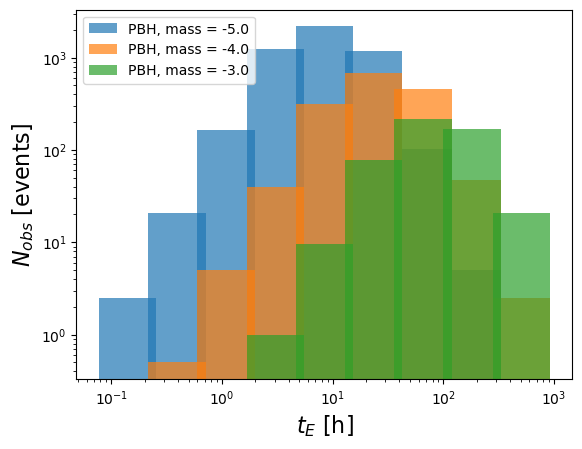

In [ ]:
m_pbhs = np.logspace(-5,-3,3)

for m in m_pbhs:
    s = Survey(l, b, ds, obsTime, survey_area, n_sources=n_sources)
    s.add_pbh(m, f_dm)
    s.add_ffp(mlow, alpha)
    num_pbh, num_ffp = s.get_num_events(t_es)
    
    bin_centers = np.sqrt(t_es[1:] * t_es[:-1])
    num_pbh_center = (num_pbh[1:] + num_pbh[:-1]) / 2
    num_ffp_center = (num_ffp[1:] + num_ffp[:-1]) / 2

    plt.bar(bin_centers, num_pbh_center, label="PBH, mass = " + str(np.log10(m)), width = np.diff(t_es), alpha = 0.7)

plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$N_{obs}$ [events]", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

### Density of FFPs and PBHs

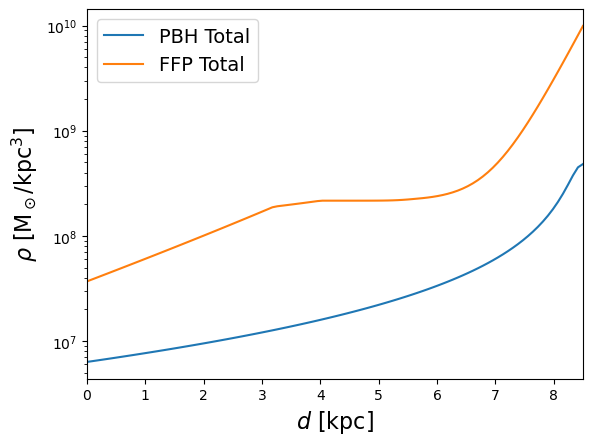

In [ ]:
# Define values for the x-axis
d = np.linspace(1e-3, rEarth, num=100)
z = 0
# Calculate the density values for each component
rho_PBH_arr = [s.pbh.density(dist_mw(i)) for i in d]

#! Careful! Right now this is the stellar density, not the FFP density
#TODO Weight by the mass function and number of ffps per star
rho_FFP_arr = [rho_FFPs(i) for i in d]


# Create the log plot
plt.plot(d, rho_PBH_arr, label="PBH Total")
plt.plot(d, rho_FFP_arr, label="FFP Total")


# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(0, rEarth)
# plt.ylim(1e-15, 1e-7)

# Show the plot
plt.show()


The densities are way diff

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()